In [1]:
import sys
sys.path.append('../')

import sqlite3
import pandas as pd
from src.cmesrc.config import CMESRCV2_DB
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [2]:
conn = sqlite3.connect(CMESRCV2_DB)
cur = conn.cursor()
conn.execute("PRAGMA foreign_keys = ON")

In [3]:
df = pd.read_sql("""
            SELECT strftime('%Y', HDS.obs_start) as year, FCHA.verification_score, COUNT(DISTINCT HDS.harpnum || '-' || HDS.cme_id) as count
            FROM HARPS_DATASET_SLICES HDS
            LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
            ON FCHA.cme_id = HDS.cme_id
            WHERE HDS.cme_id IS NOT NULL
            GROUP BY strftime('%Y', obs_start), FCHA.verification_score;
            """, conn)

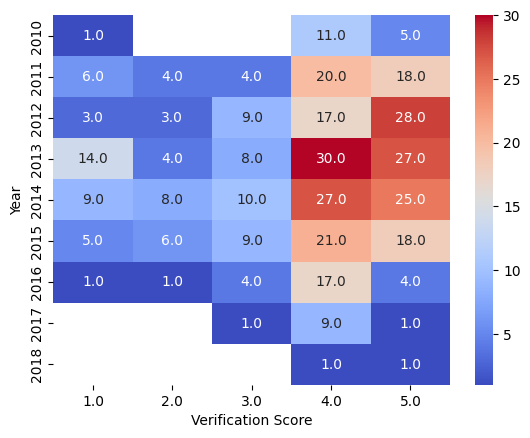

In [4]:
# Pivot the DataFrame
pivot_df = df.pivot(index='year', columns='verification_score', values='count')

# Plot heatmap
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="coolwarm")
plt.xlabel('Verification Score')
plt.ylabel('Year')
plt.show()

In [5]:
df["count"].sum()

390

In [6]:
# To investigate missing CMEs, let's see the distribution of the SHARPS longitudes

missing = pd.read_sql("""
                      SELECT FCHA.cme_id, FCHA.harpnum, H.start, C.cme_date, (PHBB.londtmin + PHBB.londtmax)/2 as lon, HDR.reason FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                      INNER JOIN HARPS H
                      ON FCHA.harpnum = H.harpnum
                      INNER JOIN CMES C
                      ON C.cme_id = FCHA.cme_id
                      LEFT JOIN HARPS_BBOX PHBB
                      ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.timestamp
                      LEFT JOIN HARPS_DATASET_SLICES HDS
                      ON HDS.cme_id = FCHA.cme_id
                      LEFT JOIN HARPS_DATASET_REJECTED_SLICES HDR
                      ON FCHA.harpnum = HDR.harpnum AND C.cme_date BETWEEN HDR.pred_start AND HDR.pred_end
                      WHERE HDS.cme_id IS NULL
                      """, conn)

all_cmes = pd.read_sql("""
                      SELECT FCHA.cme_id, FCHA.harpnum, (PHBB.londtmin + PHBB.londtmax)/2 as lon FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                      INNER JOIN CMES C
                      ON C.cme_id = FCHA.cme_id
                      LEFT JOIN HARPS_BBOX PHBB
                      ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.timestamp
                      """, conn)


non_missing = pd.read_sql("""
                      SELECT FCHA.cme_id, FCHA.harpnum, (PHBB.londtmin + PHBB.londtmax)/2 as lon, HDR.reason FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                      INNER JOIN CMES C
                      ON C.cme_id = FCHA.cme_id
                      LEFT JOIN HARPS_BBOX PHBB
                      ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.timestamp
                      LEFT JOIN HARPS_DATASET_SLICES HDS
                      ON HDS.cme_id = FCHA.cme_id
                      LEFT JOIN HARPS_DATASET_REJECTED_SLICES HDR
                      ON FCHA.harpnum = HDR.harpnum AND C.cme_date BETWEEN HDR.pred_start AND HDR.pred_end
                      WHERE HDS.cme_id IS NOT NULL
                      """, conn)

missing["start"] = pd.to_datetime(missing["start"])
missing["cme_date"] = pd.to_datetime(missing["cme_date"])

In [7]:
print(len(missing), len(missing.dropna(subset=['lon'])))

6149 6149


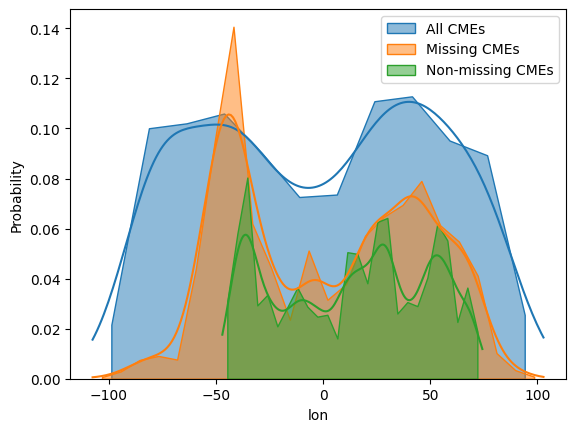

In [11]:
# Plot distribution of longitudes for missing and non-missing CMEs as well as all CMEs
fig, ax = plt.subplots()
# Dont want the bars
sns.histplot(all_cmes["lon"], label="All CMEs", kde=True, ax=ax, stat="probability", element="poly")
sns.histplot(missing.dropna(subset=['lon'])["lon"], label="Missing CMEs", kde=True, ax=ax, stat="probability", element="poly")
sns.histplot(non_missing["lon"], label="Non-missing CMEs", kde=True, ax=ax, stat="probability", element="poly")
plt.legend()

In [12]:
set(missing["reason"])

{None, 'missing_images', 'unclear_cme_present'}

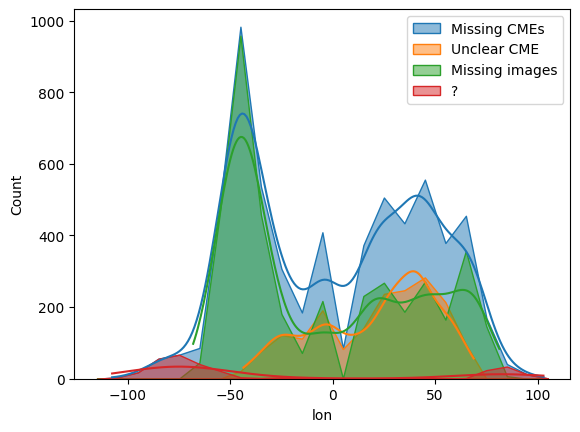

In [13]:
fig, ax = plt.subplots()

bins = np.arange(-120, 120, 10)
sns.histplot(missing.dropna(subset=['lon'])["lon"], bins=bins, label="Missing CMEs", kde=True, ax=ax, stat="count", element="poly")
sns.histplot(missing[missing["reason"] == "unclear_cme_present"].dropna(subset=['lon'])["lon"], bins=bins, label="Unclear CME", kde=True, ax=ax, stat="count", element="poly")
sns.histplot(missing[missing["reason"] == "missing_images"].dropna(subset=['lon'])["lon"], bins=bins, label="Missing images", kde=True, ax=ax, stat="count", element="poly")
sns.histplot(missing[missing["reason"].isnull()].dropna(subset=['lon'])["lon"], bins=bins, label="?", kde=True, ax=ax, stat="count", element="poly")
plt.legend()

In [14]:
a = missing[missing["reason"].isnull()].copy()
a["time_diff"] = (a["cme_date"] - a["start"])
a["time_diff"] = [val.total_seconds() / 3600 for val in a["time_diff"]]
a

,cme_id,harpnum,start,cme_date,lon,reason,time_diff
0,20100501071205111,2,2010-05-01 00:12:00,2010-05-01 07:12:05,-24.518200,None,7.001389
11,20100612013139289,54,2010-06-11 06:24:00,2010-06-12 01:31:39,48.381100,None,19.127500
12,20100613060605250,49,2010-06-08 03:36:00,2010-06-13 06:06:05,83.274902,None,122.501389
45,20100827101205242,135,2010-08-15 08:12:00,2010-08-27 10:12:05,77.966750,None,290.001389
46,20100911020006065,175,2010-09-10 10:48:00,2010-09-11 02:00:06,-87.118351,None,15.201667
...,...,...,...,...,...,...,...
5871,20170815140005096,7107,2017-08-14 02:24:00,2017-08-15 14:00:05,-69.433703,None,35.601389
5920,20170831041205070,7117,2017-08-28 22:48:00,2017-08-31 04:12:05,-67.102501,None,53.401389
6113,20170925221205112,7148,2017-09-24 19:48:00,2017-09-25 22:12:05,-85.062050,None,26.401389
6114,20171021000005098,7169,2017-10-20 22:48:00,2017-10-21 00:00:05,-90.862400,None,1.201389


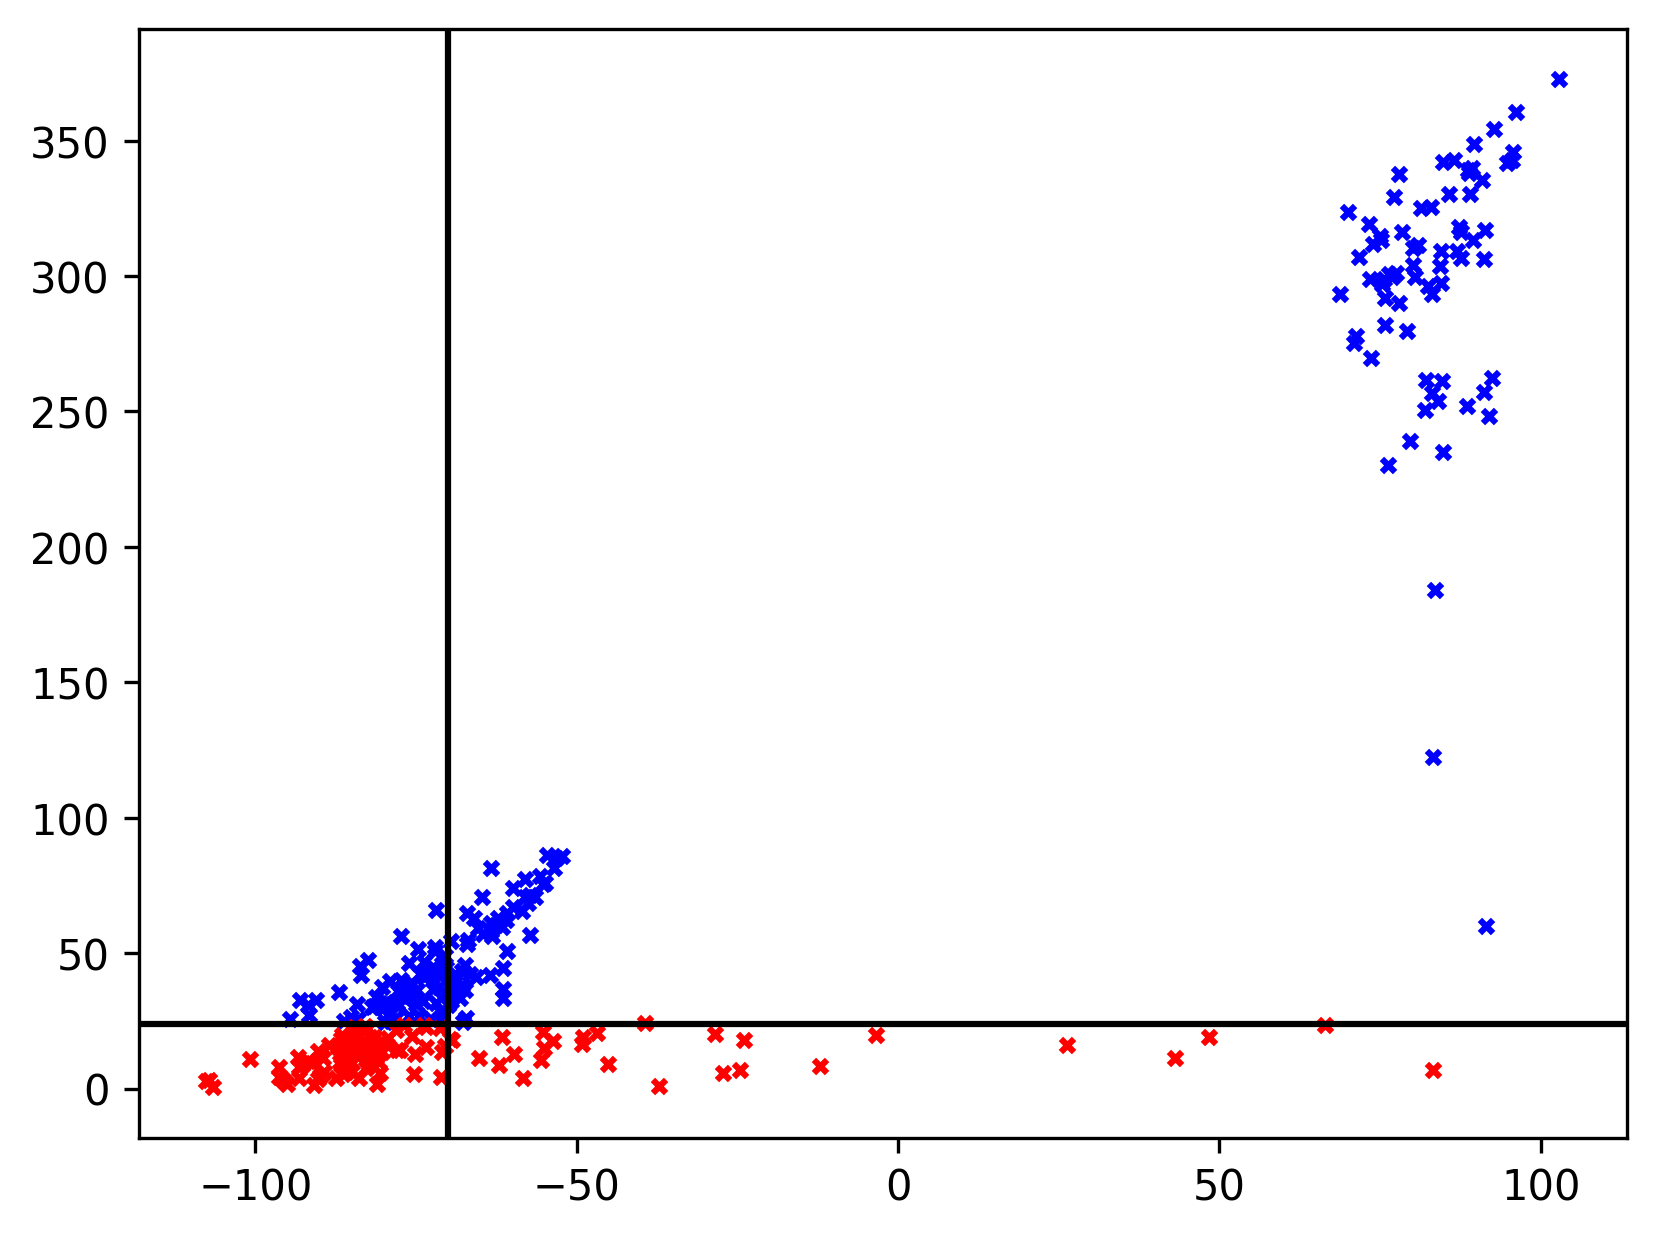

In [15]:
fig, ax = plt.subplots(dpi=300)
mask = a["time_diff"] < 24.5
ax.scatter(a[~mask]["lon"], a[~mask]["time_diff"], marker="x", c="b", s=10)
ax.scatter(a[mask]["lon"], a[mask]["time_diff"], marker="x", c="r", s=10)
ax.axhline(24, c="k")
ax.axvline(-70, c="k")

In [16]:
lifetimes = pd.read_sql("""
                        SELECT H.harpnum, FCHA.cme_id, H.end, H.start, FCHA.verification_score FROM HARPS H
                        INNER JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
                        ON FCHA.harpnum = H.harpnum
                        """, conn)
lifetimes["end"] = pd.to_datetime(lifetimes["end"])
lifetimes["start"] = pd.to_datetime(lifetimes["start"])

lifetimes["duration"] = lifetimes["end"] - lifetimes["start"]

In [17]:
lifetimes[lifetimes["duration"] < timedelta(days=3)]

,harpnum,cme_id,end,start,verification_score,duration
121,899,20110925002407263,2011-09-26 15:36:00,2011-09-24 01:00:00,2.0,2 days 14:36:00
237,1633,20120502021205272,2012-05-02 07:24:00,2012-05-01 19:24:00,4.0,0 days 12:00:00
390,2553,20130311211735262,2013-03-12 05:12:00,2013-03-09 09:24:00,5.0,2 days 19:48:00
774,4968,20141220012557216,2014-12-20 08:36:00,2014-12-19 14:00:00,5.0,0 days 18:36:00


In [18]:
too_soon_cmes = pd.read_sql("""
SELECT H.harpnum, FCHA.cme_id, (strftime('%s', C.cme_date) - strftime('%s', H.start)) / 3600.0 AS diff FROM HARPS H
                            INNER JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
                            ON FCHA.harpnum = H.harpnum
                            INNER JOIN CMES C
                            ON C.cme_id = FCHA.cme_id
""", conn)
mask = too_soon_cmes["diff"] < 24.99

In [19]:
too_soon_cmes[mask]

,harpnum,cme_id,diff
0,2,20100501071205111,7.001389
6,54,20100612013139289,19.127500
18,175,20100911020006065,15.201667
20,187,20100922042405088,22.801389
21,218,20101013171206064,14.801667
...,...,...,...
986,7034,20170601021205089,12.401389
987,7034,20170601054805080,16.001389
988,7034,20170601082405087,18.601389
1012,7169,20171021000005098,1.201389


In [20]:
real_70_lim = pd.read_sql("""
WITH harps_start AS (
                          SELECT HBB.harpnum, min(HBB.timestamp) as timestamp
                          FROM HARPS_BBOX HBB
                          WHERE HBB.LONDTMIN > -70
                          GROUP BY HBB.harpnum
),
harps_end AS (
                          SELECT HBB.harpnum, max(HBB.timestamp) as timestamp 
                          FROM HARPS_BBOX HBB
                          WHERE HBB.LONDTMAX < 70
                          GROUP BY HBB.harpnum
)
SELECT HS.harpnum,
       HS.timestamp AS start, 
       HE.timestamp AS end,
       (strftime('%s', C.cme_date) - strftime('%s', HS.timestamp)) / 3600.0 AS start_diff,
       (strftime('%s', C.cme_date) - strftime('%s', HE.timestamp)) / 3600.0 AS end_diff,
       C.cme_date,
       FCHA.verification_score,
       C.cme_id FROM harps_start HS 
INNER JOIN harps_end HE
ON HE.harpnum = HS.harpnum
INNER JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
ON FCHA.harpnum = HS.harpnum
INNER JOIN CMES C
ON C.cme_id = FCHA.cme_id
                          """, conn)

real_70_lim                        

,harpnum,start,end,start_diff,end_diff,cme_date,verification_score,cme_id
0,2,2010-05-01 00:12:00,2010-05-05 12:00:00,7.001389,-100.798611,2010-05-01 07:12:05,4.0,20100501071205111
1,8,2010-05-02 14:48:00,2010-05-07 13:36:00,113.301389,-5.498611,2010-05-07 08:06:05,4.0,20100507080605317
2,8,2010-05-02 14:48:00,2010-05-07 13:36:00,134.701667,15.901667,2010-05-08 05:30:06,2.0,20100508053006310
3,24,2010-05-19 02:48:00,2010-05-26 14:36:00,111.301389,-68.498611,2010-05-23 18:06:05,5.0,20100523180605999
4,25,2010-05-19 04:48:00,2010-05-25 23:36:00,129.301389,-33.498611,2010-05-24 14:06:05,5.0,20100524140605999
...,...,...,...,...,...,...,...,...
1013,7229,2018-01-14 04:36:00,2018-01-22 11:36:00,190.602222,-8.397778,2018-01-22 03:12:08,4.0,20180122031208275
1014,7237,2018-02-06 12:48:00,2018-02-15 09:24:00,132.621667,-79.978333,2018-02-12 01:25:18,5.0,20180212012518999
1015,7240,2018-02-26 00:48:00,2018-03-02 12:24:00,96.627778,-10.972222,2018-03-02 01:25:40,3.0,20180302012540271
1016,7246,2018-03-31 00:00:00,2018-04-07 03:00:00,9.801389,-161.198611,2018-03-31 09:48:05,4.0,20180331094805097


In [54]:
missed_close_to_limb = real_70_lim[(real_70_lim["start_diff"] < 24) | (real_70_lim["end_diff"] > 24)]["cme_id"].unique()
real_70_lim[(real_70_lim["start_diff"] < 24) | (real_70_lim["end_diff"] > 24)]["verification_score"].value_counts()

4.0    211
2.0    114
5.0     45
1.0     32
3.0     23
Name: verification_score, dtype: int64

In [30]:
missing_cmes = pd.read_sql("""
                    SELECT DISTINCT FCHA.cme_id FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                    LEFT JOIN HARPS_DATASET_SLICES HDS
                    ON HDS.cme_id = FCHA.cme_id
                    WHERE HDS.cme_id IS NULL
                    """, conn).to_numpy().flatten()

unaccounted_cmes = [cme for cme in missing_cmes if cme not in missed_close_to_limb]

In [53]:
unaccounted_cmes_scores = pd.read_sql("""
                    SELECT FCHA.cme_id, FCHA.verification_score FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                    INNER JOIN CMES C
                    ON C.cme_id = FCHA.cme_id
                    LEFT JOIN HARPS_DATASET_SLICES HDS
                    ON HDS.cme_id = FCHA.cme_id
                    WHERE FCHA.cme_id IN (""" + ",".join([str(cme) for cme in unaccounted_cmes]) + """) AND HDS.cme_id IS NULL
                                       """, conn)

unaccounted_cmes_scores["verification_score"].value_counts()

4.0    70
5.0    41
1.0    38
2.0    37
3.0    19
Name: verification_score, dtype: int64

In [51]:
unaccounted_cmes_reasons = pd.read_sql("""
                    SELECT FCHA.cme_id, HDR.reason FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                    INNER JOIN CMES C
                    ON C.cme_id = FCHA.cme_id
                    LEFT JOIN HARPS_DATASET_SLICES HDS
                    ON HDS.cme_id = FCHA.cme_id
                    LEFT JOIN HARPS_DATASET_REJECTED_SLICES HDR
                    ON FCHA.harpnum = HDR.harpnum AND C.cme_date BETWEEN HDR.pred_start AND HDR.pred_end
                    WHERE FCHA.cme_id IN (""" + ",".join([str(cme) for cme in unaccounted_cmes]) + """) AND HDS.cme_id IS NULL
                    GROUP BY FCHA.cme_id, HDR.reason
                                       """, conn)

unaccounted_cmes_reasons

,cme_id,reason
0,20100508053006310,missing_images
1,20100508053006310,unclear_cme_present
2,20100613063005294,missing_images
3,20100613063005294,unclear_cme_present
4,20101115231205128,unclear_cme_present
...,...,...
255,20170906122405999,missing_images
256,20170907102406254,missing_images
257,20170907151208254,missing_images
258,20170907184805259,missing_images


In [48]:
# How many CMEs are rejected because missing_images alone, unclear_cme_present alone and how many because of both?
# Entries are cme_id, reason so we can't just count the number of entries
# Instead we have to look cme_id by cme_id
# We can do this by grouping by cme_id and counting the number of entries

images_only = 0
unclear_only = 0
both = 0
unknown = 0
unknown_ids = []

for cme_id, rows in unaccounted_cmes_reasons.groupby("cme_id"):
    if len(rows) == 1:
        if rows["reason"].iloc[0] == "missing_images":
            images_only += 1
        elif rows["reason"].iloc[0] == "unclear_cme_present":
            unclear_only += 1
        else:
            unknown += 1
            unknown_ids.append(cme_id)
    else:
        both += 1

print(images_only, unclear_only, both, unknown)

82 66 55 2


In [49]:
unaccounted_cmes_reasons[unaccounted_cmes_reasons["cme_id"].isin(unknown_ids)]
# 20120502021205272 Was rejected because the HARPs lives for less than 24 hours
# 20130123141205351 Was rejected because the CME happens 24hours and 12 minutes after the first image
# Since we start our slices half an hour later than the first image, this CME is lost

,cme_id,reason
66,20120502021205272,None
111,20130123141205351,None


In [59]:
all_missing_scores = pd.read_sql("""
                        SELECT FCHA.cme_id, FCHA.verification_score FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                        LEFT JOIN HARPS_DATASET_SLICES HDS
                        ON HDS.cme_id = FCHA.cme_id
                        WHERE HDS.cme_id IS NULL
                        GROUP BY FCHA.cme_id
""", conn)
all_missing_scores["verification_score"].value_counts().sum()

629

In [61]:

all_matched_scores = pd.read_sql("""
                        SELECT FCHA.cme_id, FCHA.verification_score FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
                        LEFT JOIN HARPS_DATASET_SLICES HDS
                        ON HDS.cme_id = FCHA.cme_id
                        WHERE HDS.cme_id IS NOT NULL
                        GROUP BY FCHA.cme_id
""", conn)
all_matched_scores["verification_score"].value_counts()

4.0    153
5.0    127
3.0     45
1.0     39
2.0     26
Name: verification_score, dtype: int64